<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods</font></h1>
    
<h2 align=center><font size = 3>Clustering neighborhoods in New York City
 : Recipient groups of healthcare service </font></h2>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

The objective of this project is to help government health agencies and private companies that provide health products/services get a better understanding of the customers/citizens of New York city, especially  the Manhattan data, the Brooklyn, and the Staten Island. 

A living environment has a significant influence on individual health status and in this project we will try to analize health related environment each neighborhoods based on the population density, income, accessibility to healthcare (which in this project will be measured by the number of medical centers) and participation of physical activities/sports(which in this project will be measured by the number of outdoor/sports facilities). 

Then we will segment neighborhoods into several groups so that the agencies and companies can establish a public campaign or marketing strategy with different approaches acoording to each clusters

## 2. Data <a name="data"></a>

Given that we access the living environment directly related to health,
there are four factors to be measured:
* number of medical centers in the neighborhood (e.g. hospitals, doctor's office, etc)
* number of sports facilities in the neighborhood (e.g. gym, yoga studiio, etc)
* GDP, medican income and poverty rate of the borough to which the neighborhood belongs
* density rate of the borough to which the neighborhood belongs

Data sources:                                                
* number of medical centers and sports facilities in every neighborhood will be obtained using **Foursquare API**
* GDP, medican income, poverty rate, and density rate of the borough will be obtained using **Wikipedia** which specifies the original sources of the data

### 2.1. Gather Data of Location of Neighborhoods of New York

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') 
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#converting 2d list into 1d list using chain.from_iterables
from itertools import chain 
print('Libraries imported.')

Libraries imported.


#### Download csv file and get the json data

In [2]:
# !pip install wget 

In [3]:
import wget
# In Window setting !wget ~ doesnt work as the line below, so I need to use the url and another process 
#!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
filename = wget.download(url)
print('Data downloaded!')
filename

100% [............................................................................] 115774 / 115774Data downloaded!


'newyork_data (1).json'

In [4]:
# Loading json data
with open('newyork_data.json') as json_data:
    raw_data = json.load(json_data)

In [6]:
# Since the features key is basically a list of the neighborhoods. let's gather neighborhoods data
newyork_data = raw_data['features']
newyork_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the json data into a pandas dataframe

In [7]:
# Transforming this data of nested Python dictionaries into a pandas dataframe
column_names = ['Borough', 'Neighborhood','Latitude','Longitude']
newyork_df = pd.DataFrame(columns=column_names)

for data in newyork_data:
    borough = data['properties']['borough']
    neighborhoods_name = data['properties']['name']
    neighborhoods_lat = data['geometry']['coordinates'][1]
    neighborhoods_lon = data['geometry']['coordinates'][0]
    newyork_df = newyork_df.append({'Borough': borough,
                                          'Neighborhood': neighborhoods_name,
                                          'Latitude': neighborhoods_lat,
                                          'Longitude': neighborhoods_lon}, ignore_index=True)
    # pandas.DataFrame.append: Append rows of other to the end of object, a different name of columns will be added unless there are already there.
    # ignore_index=True :  the resulting axis will be labeled 0, 1, …, n - 1.

newyork_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
# print out the numbe of Boroughs and Neighborhoods
print(len(newyork_df['Borough'].unique()),"Boroughs", newyork_df.shape[0], "Neighborhoods")

5 Boroughs 306 Neighborhoods


#### Use geopy library to get the latitude and longitude values of New York City

In [9]:
address = 'New York City, NY'
# In order to define an instance of the geocoder, we need to define a user_agent
location = Nominatim(user_agent="ny_explorer").geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of NY : {},{}'.format(latitude,longitude))

The coordinates of NY : 40.7127281,-74.0060152


#### Create a map of New York with neighborhoods superimposed on top.


In [10]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lon, borough, neighborhood in zip(newyork_df['Latitude'],
                                           newyork_df['Longitude'],
                                           newyork_df['Borough'],
                                           newyork_df['Neighborhood']):
    label = folium.Popup(str(neighborhood)+','+ str(borough), parse_html=True)
    folium.CircleMarker([lat, lon], radius=4, popup=label, color='blue',
                        fill=True, fill_color='#3186cc',fill_opacity=0.7,
                        parse_html=False).add_to(map_ny)  
map_ny

#### Slice the original dataframe and create a new dataframe of three neighborhoods
For the reason of the limited amount of API call of Foursquare, let's simplify the above map and segment and cluster only the neighborhoods in three boroughs:'Manhattan','Brooklyn',and 'Staten Island'. These three boroughs are selected based on GDP and they respectively have low, middle and high GDP.  We could've selected random three neighborhoods, however, in this way we will be able to not only compare the geographical segmentation and clusters using the health factors at the end of this project, but also see if there is any relation between the wealth of each borough and the accesibilities of heathcare and sports facility. 

Thus, we will slice the original dataframe and create a new dataframe of the Manhattan data, the Brooklyn, and the Staten Island. 

In [11]:
# create a new df with only three boroughs data
ny3 = ['Manhattan','Brooklyn', 'Staten Island']
ny3_df = newyork_df[newyork_df['Borough'].str.contains('|'.join(ny3))]
ny3_df = ny3_df.sort_values(by=['Borough','Neighborhood'])
ny3_df = ny3_df.reset_index(drop=True)
ny3_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bath Beach,40.599519,-73.998752
1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785
3,Brooklyn,Bensonhurst,40.611009,-73.995180
4,Brooklyn,Bergen Beach,40.615150,-73.898556


In [12]:
# Add a new column to mark each Borrow in order to distinguish 
idx = ny3_df['Borough'].map({'Brooklyn':1, 'Manhattan':2, 'Staten Island':3})
idx = pd.DataFrame(idx).rename(columns={'Borough':'idx'})
ny3_df = pd.concat([ny3_df,idx], axis=1)
# sort columns in a right way
fixed_columns = ['idx','Borough','Neighborhood','Latitude','Longitude']
ny3_df = ny3_df.loc[:, fixed_columns]
ny3_df.head()

,idx,Borough,Neighborhood,Latitude,Longitude
0,1,Brooklyn,Bath Beach,40.599519,-73.998752
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556


In [13]:
# Total number of neighborhoods
ny3_df.shape

(173, 5)

In [14]:
# Check how many neighborhoods in each boroughs
ny3_df.groupby(['Borough']).count()

,idx,Neighborhood,Latitude,Longitude
Borough,,,,
Brooklyn,70,70,70,70
Manhattan,40,40,40,40
Staten Island,63,63,63,63


#### Visualize the three boroughs on map

In [15]:
# set color scheme for the clusters
map_ny3 = folium.Map(location=[latitude, longitude], zoom_start=10)

k =3
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, neighborhood, borough, cluster in zip(ny3_df['Latitude'],
                                           ny3_df['Longitude'],
                                           ny3_df['Neighborhood'],
                                           ny3_df['Borough'],
                                           ny3_df['idx']):
    label = folium.Popup(str(neighborhood)+","+str(borough), parse_html=True)
    folium.CircleMarker([lat,lon], radius=5, popup=label, color=rainbow[cluster-1],fill=True, fill_color=rainbow[cluster-1],fill_opacity=0.7).add_to(map_ny3)
    
map_ny3

### 2.2. Gather Data of Nearby Healthcare and Sports Facilities of the Neighborhoods

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on healthcare and sports facilities in each neighborhood.

In [16]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

In [17]:
# Get Foursqueare Categories List(https://developer.foursquare.com/docs/build-with-foursquare/categories/)
url_cat = "https://developer.foursquare.com/docs/build-with-foursquare/categories/"
html = requests.get(url_cat).text
soup_cat = BeautifulSoup(html, 'html5lib')
print(soup_cat.title)

<title data-react-helmet="true">Venue Categories | Build with Foursquare</title>


### _2.2.a. Get the category list and id_

#### Create a function to get catagory data and make dataframe 

In [18]:
def get_cat_id_df(soup_cat, category_parent):
    # Get a category list
    cat_data = soup_cat.find('h3', text=category_parent).parent.find_all('h3',text=True)
    cat_df = pd.DataFrame([cat.string for cat in cat_data])
    # Get a category id list
    id_data = soup_cat.find('h3', text=category_parent).parent.find_all('p',text=True)
    id_df = pd.DataFrame([id_.string for id_ in id_data])
    # join the two lists/dfs
    cat_id_df = pd.concat([cat_df,id_df], axis=1)
    cat_id_df.columns = ['Category', 'id']
 
    return cat_id_df

#### Get category & id of Outdoors & Recreation

In [19]:
cat_sports = get_cat_id_df(soup_cat, 'Athletics & Sports')
# save the parent id just in case
cat_sports_parent_id = cat_sports.iloc[0]['id']
# cat_sports = cat_sports.rename(columns=cat_sports.iloc[0]).drop(0).reset_index(drop=True)
cat_sports.columns = ['Athletics & Sports','id']
cat_sports = cat_sports.drop(0).reset_index(drop=True)

cat_sports

,Athletics & Sports,id
0,Badminton Court,52e81612bcbc57f1066b7a2b
1,Baseball Field,4bf58dd8d48988d1e8941735
2,Basketball Court,4bf58dd8d48988d1e1941735
3,Bowling Green,52e81612bcbc57f1066b7a2f
4,Curling Ice,56aa371be4b08b9a8d57351a
5,Golf Course,4bf58dd8d48988d1e6941735
6,Golf Driving Range,58daa1558bbb0b01f18ec1b0
7,Gym / Fitness Center,4bf58dd8d48988d175941735
8,Boxing Gym,52f2ab2ebcbc57f1066b8b47
9,Climbing Gym,503289d391d4c4b30a586d6a


In [20]:
cat_sports_parent_id

'4f4528bc4b90abdf24c9de85'

In [21]:
# Get only category Id
cat_sports_name = list(cat_sports['Athletics & Sports'])
print(cat_sports_name)

['Badminton Court', 'Baseball Field', 'Basketball Court', 'Bowling Green', 'Curling Ice', 'Golf Course', 'Golf Driving Range', 'Gym / Fitness Center', 'Boxing Gym', 'Climbing Gym', 'Cycle Studio', 'Gym Pool', 'Gymnastics Gym', 'Gym', 'Martial Arts Dojo', 'Outdoor Gym', 'Pilates Studio', 'Track', 'Weight Loss Center', 'Yoga Studio', 'Hockey Field', 'Hockey Rink', 'Paintball Field', 'Rugby Pitch', 'Skate Park', 'Skating Rink', 'Soccer Field', 'Sports Club', 'Squash Court', 'Tennis Court', 'Volleyball Court']


#### Get category & id of Medical Center

In [22]:
cat_medical = get_cat_id_df(soup_cat, 'Medical Center')
# save the parent id just in case
cat_medical_parent_id = cat_medical.iloc[0]['id']
# cat_medical_parent_id
cat_medical.columns = ['Medical Center','id']
cat_medical = cat_medical.drop([0,17]).reset_index(drop=True)
cat_medical

,Medical Center,id
0,Acupuncturist,52e81612bcbc57f1066b7a3b
1,Alternative Healer,52e81612bcbc57f1066b7a3c
2,Chiropractor,52e81612bcbc57f1066b7a3a
3,Dentist's Office,4bf58dd8d48988d178941735
4,Doctor's Office,4bf58dd8d48988d177941735
5,Emergency Room,4bf58dd8d48988d194941735
6,Eye Doctor,522e32fae4b09b556e370f19
7,Hospital,4bf58dd8d48988d196941735
8,Hospital Ward,58daa1558bbb0b01f18ec1f7
9,Maternity Clinic,56aa371be4b08b9a8d5734ff


In [23]:
cat_medical_parent_id

'4bf58dd8d48988d104941735'

In [24]:
# Get only category Id
cat_medical_name = list(cat_medical['Medical Center'])
print(cat_medical_name)

['Acupuncturist', 'Alternative Healer', 'Chiropractor', "Dentist's Office", "Doctor's Office", 'Emergency Room', 'Eye Doctor', 'Hospital', 'Hospital Ward', 'Maternity Clinic', 'Medical Lab', 'Mental Health Office', 'Nutritionist', 'Physical Therapist', 'Rehab Center', 'Urgent Care Center']


### 2.2.b. _Search nearby venues in the categories_

#### Define Foursquare Credentials and Version

In [25]:
CLIENT_ID = '' # deleted after the project 
CLIENT_SECRET = ''# deleted after the project 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius= 1000  # Since neighborhoods has the size of around 1000meters
# Using radius=1000 to make sure we have overlaps/full coverage so we don't miss any facilities

#### Create a function to get nearby venues each neighborhoods

In [26]:
def getVenuesbyCat(neighborhoods, latitudes, longitudes, categoryId):
    
    venues_list=[]
    for neigh, lat, lon in zip(neighborhoods, latitudes, longitudes):          
        # create the API request URL
        url_cat = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lon, 
                    radius, 
                    LIMIT, categoryId)

                # make the GET request
        results = requests.get(url_cat).json()["response"]['venues']
#         results
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neigh, 
            lat, 
            lon, 
            v['name'], #venue name
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("Done")
    return(nearby_venues)

#### Search nearby venues of Athletics & Sports

In [27]:
venues_sports = getVenuesbyCat(neighborhoods=ny3_df['Neighborhood'],
                                   latitudes=ny3_df['Latitude'],
                                   longitudes=ny3_df['Longitude'], categoryId=cat_sports_parent_id)

Done


In [28]:
print(venues_sports.shape)
venues_sports.head()

(4750, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bath Beach,40.599519,-73.998752,Planet Fitness,40.604567,-73.997861,Gym / Fitness Center
1,Bath Beach,40.599519,-73.998752,Matchpoint NYC,40.595070,-74.001411,Tennis Court
2,Bath Beach,40.599519,-73.998752,Bally Total Fitness,40.605701,-73.999844,Gym / Fitness Center
3,Bath Beach,40.599519,-73.998752,New York Sports Clubs,40.593131,-73.997427,Gym / Fitness Center
4,Bath Beach,40.599519,-73.998752,Dolphin Fitness Clubs,40.598768,-73.989248,Gym


In [29]:
# Check if there are inappropriate categories in the result
venues_sports['Venue Category'].unique()

array(['Gym / Fitness Center', 'Tennis Court', 'Gym', 'Yoga Studio',
       'Martial Arts School', 'Gymnastics Gym', 'Weight Loss Center',
       'Baseball Field', 'Athletics & Sports', 'Track', 'Pilates Studio',
       'Arcade', 'Basketball Court', "Doctor's Office",
       'Community Center', 'Boxing Gym', 'Skate Park', 'Skating Rink',
       'Sports Club', 'Playground', 'Hockey Field', 'Gym Pool',
       'Climbing Gym', 'Outdoor Gym', 'Park', 'College Gym',
       'Soccer Field', 'Residential Building (Apartment / Condo)',
       'Non-Profit', 'Golf Course', 'Massage Studio', 'Volleyball Court',
       'Dance Studio', 'Cycle Studio', 'Rugby Pitch', 'Baseball Stadium',
       'Football Stadium', 'Club House', 'College Rec Center',
       'Medical Center', 'Chiropractor', 'High School', 'Squash Court',
       'Golf Driving Range', 'Event Space', 'Field', 'Clothing Store',
       'Bowling Green', 'Recreation Center', 'Pool', 'Building',
       'Bike Trail', 'Corporate Amenity', 'Physic

In [30]:
cat_sports_name

['Badminton Court',
 'Baseball Field',
 'Basketball Court',
 'Bowling Green',
 'Curling Ice',
 'Golf Course',
 'Golf Driving Range',
 'Gym / Fitness Center',
 'Boxing Gym',
 'Climbing Gym',
 'Cycle Studio',
 'Gym Pool',
 'Gymnastics Gym',
 'Gym',
 'Martial Arts Dojo',
 'Outdoor Gym',
 'Pilates Studio',
 'Track',
 'Weight Loss Center',
 'Yoga Studio',
 'Hockey Field',
 'Hockey Rink',
 'Paintball Field',
 'Rugby Pitch',
 'Skate Park',
 'Skating Rink',
 'Soccer Field',
 'Sports Club',
 'Squash Court',
 'Tennis Court',
 'Volleyball Court']

In [31]:
# Get names of indexes for the correct category names and filter the result
keep_row = cat_sports_name
keep_row_idx=[]
for value in keep_row:
    keep_row_idx.append(venues_sports[venues_sports['Venue Category'] == value ].index)

keep_row_idx_flat = list(chain.from_iterable(keep_row_idx))
    
venues_sports = venues_sports.iloc[keep_row_idx_flat]
venues_sports.reset_index(drop=True, inplace=True)
venues_sports.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bath Beach,40.599519,-73.998752,kings Bay Field,40.595401,-74.000762,Baseball Field
1,Bath Beach,40.599519,-73.998752,Caesars Bay baseball Field,40.595660,-74.002650,Baseball Field
2,Bay Ridge,40.625801,-74.030621,68th Precinct Field,40.627708,-74.038990,Baseball Field
3,Bay Ridge,40.625801,-74.030621,St. Anselm Field,40.624530,-74.018494,Baseball Field
4,Bay Ridge,40.625801,-74.030621,Bobby Bello Baseball Field,40.633468,-74.038513,Baseball Field


In [32]:
# Check whether the filter worked well
venues_sports['Venue Category'].unique()

array(['Baseball Field', 'Basketball Court', 'Bowling Green',
       'Golf Course', 'Golf Driving Range', 'Gym / Fitness Center',
       'Boxing Gym', 'Climbing Gym', 'Cycle Studio', 'Gym Pool',
       'Gymnastics Gym', 'Gym', 'Outdoor Gym', 'Pilates Studio', 'Track',
       'Weight Loss Center', 'Yoga Studio', 'Hockey Field',
       'Paintball Field', 'Rugby Pitch', 'Skate Park', 'Skating Rink',
       'Soccer Field', 'Sports Club', 'Squash Court', 'Tennis Court',
       'Volleyball Court'], dtype=object)

In [33]:
# Check how many sports venues each neighborhoods have 
venues_sports.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Annadale,6,6,6,6,6,6
Arden Heights,5,5,5,5,5,5
Arlington,1,1,1,1,1,1
Arrochar,12,12,12,12,12,12
Bath Beach,21,21,21,21,21,21
Battery Park City,43,43,43,43,43,43
Bay Ridge,35,35,35,35,35,35
Bay Terrace,9,9,9,9,9,9
Bedford Stuyvesant,38,38,38,38,38,38


In [34]:
venues_sports_count = venues_sports.groupby('Neighborhood').count()
venues_sports_count = venues_sports_count[['Venue']]
venues_sports_count.columns = ['Sports_Venues']

In [35]:
venues_sports_count.head()

,Sports_Venues
Neighborhood,
Annadale,6
Arden Heights,5
Arlington,1
Arrochar,12
Bath Beach,21


#### Search nearby venues of Athletics & Sports

In [36]:
venues_medical = getVenuesbyCat(neighborhoods=ny3_df['Neighborhood'],
                                   latitudes=ny3_df['Latitude'],
                                   longitudes=ny3_df['Longitude'], categoryId=cat_medical_parent_id)

Done


In [37]:
print(venues_medical.shape)
venues_medical.head()

(6178, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bath Beach,40.599519,-73.998752,Bath Animal Hospital,40.599483,-73.998509,Veterinarian
1,Bath Beach,40.599519,-73.998752,4 Legged Friends Veterinary Clinic,40.601826,-74.001945,Veterinarian
2,Bath Beach,40.599519,-73.998752,Quest Diagnostic,40.601877,-73.994775,Medical Lab
3,Bath Beach,40.599519,-73.998752,"M. Kumar, MD",40.603809,-74.002312,Doctor's Office
4,Bath Beach,40.599519,-73.998752,Haym Solomon Nursing Home,40.594777,-73.996449,Medical Center


In [38]:
# Check if there are inapropriate categories in the result 
venues_medical['Venue Category'].unique()

array(['Veterinarian', 'Medical Lab', "Doctor's Office", 'Medical Center',
       "Dentist's Office", 'Eye Doctor', 'Hospital', 'Building',
       'Acupuncturist', 'Alternative Healer', 'Chiropractor',
       'Health & Beauty Service', 'Emergency Room', 'Physical Therapist',
       'Maternity Clinic', 'Mental Health Office', 'Massage Studio',
       'Urgent Care Center', 'Optical Shop', 'Event Space',
       'Hospital Ward', 'Bakery', 'Gym / Fitness Center',
       'Assisted Living', 'Spa', 'Pharmacy', 'Rest Area',
       'Adult Education Center', 'Spiritual Center', 'Medical School',
       'Research Laboratory', 'Rehab Center', 'Pet Service', 'Hospice',
       'Business Service', 'Nutritionist', 'Blood Donation Center',
       'Government Building', 'Office', 'Fire Station',
       'Residential Building (Apartment / Condo)', 'Medical Supply Store',
       'Shoe Store', 'School', 'Yoga Studio', 'Juice Bar'], dtype=object)

In [39]:
# Add Pharmacy to the category list
cat_medical_name.append('Pharmacy')
cat_medical_name

['Acupuncturist',
 'Alternative Healer',
 'Chiropractor',
 "Dentist's Office",
 "Doctor's Office",
 'Emergency Room',
 'Eye Doctor',
 'Hospital',
 'Hospital Ward',
 'Maternity Clinic',
 'Medical Lab',
 'Mental Health Office',
 'Nutritionist',
 'Physical Therapist',
 'Rehab Center',
 'Urgent Care Center',
 'Pharmacy']

In [40]:
# Get names of indexes for the correct category names and filter the result
keep_row = cat_medical_name
keep_row_idx=[]
for value in keep_row:
    keep_row_idx.append(venues_medical[venues_medical['Venue Category'] == value ].index)

keep_row_idx_flat = list(chain.from_iterable(keep_row_idx))
    
venues_medical = venues_medical.iloc[keep_row_idx_flat]
venues_medical.reset_index(drop=True, inplace=True)
venues_medical.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bath Beach,40.599519,-73.998752,Liang's Acupuncture & Chinese Medicine,40.599600,-73.990487,Acupuncturist
1,Bedford Stuyvesant,40.687232,-73.941785,Bed Stuy Acupuncture & Massage Therapy,40.687465,-73.954545,Acupuncturist
2,Bedford Stuyvesant,40.687232,-73.941785,City Acupuncture,40.687425,-73.954433,Acupuncturist
3,Bedford Stuyvesant,40.687232,-73.941785,Doraji Acupuncture,40.685058,-73.935727,Acupuncturist
4,Boerum Hill,40.685683,-73.983748,Vitality Acupunture,40.692895,-73.991024,Acupuncturist


In [41]:
# check whether the filter worked well
venues_medical['Venue Category'].unique()

array(['Acupuncturist', 'Alternative Healer', 'Chiropractor',
       "Dentist's Office", "Doctor's Office", 'Emergency Room',
       'Eye Doctor', 'Hospital', 'Hospital Ward', 'Maternity Clinic',
       'Medical Lab', 'Mental Health Office', 'Nutritionist',
       'Physical Therapist', 'Rehab Center', 'Urgent Care Center',
       'Pharmacy'], dtype=object)

In [42]:
# Check how many healthcare venues each neighborhoods have 
venues_medical.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Annadale,8,8,8,8,8,8
Arden Heights,12,12,12,12,12,12
Arlington,6,6,6,6,6,6
Arrochar,12,12,12,12,12,12
Bath Beach,30,30,30,30,30,30
Battery Park City,41,41,41,41,41,41
Bay Ridge,36,36,36,36,36,36
Bay Terrace,20,20,20,20,20,20
Bedford Stuyvesant,27,27,27,27,27,27


In [43]:
venues_medical_count = venues_medical.groupby('Neighborhood').count()
venues_medical_count = venues_medical_count[['Venue']]
venues_medical_count.columns = ['Medical_Venues']

In [44]:
venues_medical_count.head()

,Medical_Venues
Neighborhood,
Annadale,8
Arden Heights,12
Arlington,6
Arrochar,12
Bath Beach,30


### 2.3. Get Demographics Data of New York City
Scrape data from HTML tables into a DataFrame using read_html without BeautifulSoup

#### Get demographics of New York City

In [45]:
url_demo = "https://en.wikipedia.org/wiki/Demographics_of_New_York_City"

In [46]:
# Scrape data from HTML tables into a DataFrame using read_html
demo_df = pd.read_html(url_demo, flavor='bs4', header=None)[0].iloc[0:7]                         
# Since it was too crazy to find a way to remove the html parser & multiindex of columns in "demo_df",
#simply replace it with the firs row
demo_df.columns = demo_df.iloc[0]
# drop the NaN column
demo_df = demo_df.loc[:, demo_df.columns.notnull()]
demo_df
demo_df.columns = ['Borough','County','Population(2019)',
                   'GDP(billions)','Land(mi)','Land(km)','Density(mi2)','Density(km2)']
demo_df

,Borough,County,Population(2019),GDP(billions),Land(mi),Land(km),Density(mi2),Density(km2)
0,The Bronx,Bronx,1418207,42.695,42.10,109.04,33867,13006
1,Brooklyn,Kings,2559903,91.559,70.82,183.42,36147,13957
2,Manhattan,New York,1628706,600.244,22.83,59.13,71341,27544
3,Queens,Queens,2253858,93.310,108.53,281.09,20767,8018
4,Staten Island,Richmond,476143,14.514,58.37,151.18,8157,3150
5,City of New York,City of New York,8336817,842.343,302.64,783.83,27547,10636
6,State of New York,State of New York,19453561,1731.910,47126.40,122056.82,412,159


In [47]:
# Select data to be used for analysis
demo_ny3 = demo_df[['Borough','GDP(billions)','Density(km2)']].iloc[[1,2,4]]
demo_ny3.reset_index(drop=True, inplace=True)
demo_ny3

,Borough,GDP(billions),Density(km2)
0,Brooklyn,91.559,13957
1,Manhattan,600.244,27544
2,Staten Island,14.514,3150


In [48]:
# To make object dtype as integer, it MUST convert to a string first, then an integer.
demo_ny3[['GDP(billions)','Density(km2)']] = demo_ny3[['GDP(billions)','Density(km2)']].astype(str).astype(float)
# demo_ny3.dtypes

#Count the number of neighborhoods in each boroughs
n_brook = ny3_df.groupby('Borough').count().loc['Brooklyn',['Neighborhood']].item() #.item() Extract value from cell
n_man = ny3_df.groupby('Borough').count().loc['Manhattan',['Neighborhood']].item()
n_state = ny3_df.groupby('Borough').count().loc['Staten Island',['Neighborhood']].item()
n_borough = [n_brook,n_man,n_state]
n_borough

# Divide the DataFrame1 elements by the elements of list: use Apply function which applies function by axis
demo_ny3[['GDP_avg']] = demo_ny3[['GDP(billions)']].apply(lambda x: x/n_borough, axis=0)
demo_ny3_avg = demo_ny3.drop(columns=['GDP(billions)'])

# To join two df, one df must have one of columns of other df as an index
demo_ny3_avg = demo_ny3_avg.set_index('Borough')

demo_ny3_avg.head()

,Density(km2),GDP_avg
Borough,,
Brooklyn,13957.0,1.307986
Manhattan,27544.0,15.006100
Staten Island,3150.0,0.230381


#### Get income and poverty data

In [49]:
Income_df = pd.read_html(url_demo, flavor='bs4')[7]                         
Income_df.columns = ['Borough','Median_income','Mean_income','Poverty_rate']
# Remove unwanted parts from strings in a column
# Income_df[['Median_income','Mean_income','Poverty_rate(%)']] = Income_df[['Median_income','Mean_income','Poverty_rate(%)']].applymap(lambda x: x.lstrip('$').rstrip('%'))
Income_df = Income_df.applymap(lambda x: x.lstrip('$').rstrip('%').replace(',', ''))

Income_df

,Borough,Median_income,Mean_income,Poverty_rate
0,The Bronx,34156,46298,27.1
1,Brooklyn,41406,60020,21.9
2,Manhattan,64217,121549,17.6
3,Queens,53171,67027,12.0
4,Staten Island,66985,81498,9.8
5,New York City,48631,75809,18.5
6,New York State,53514,77865,13.7
7,United States,50140,69193,13.0


In [50]:
# Select data to be used for analysis
income_ny3 = Income_df[['Borough','Median_income','Poverty_rate']].iloc[[1,2,4]]
income_ny3 = income_ny3.set_index('Borough')
income_ny3

,Median_income,Poverty_rate
Borough,,
Brooklyn,41406,21.9
Manhattan,64217,17.6
Staten Island,66985,9.8


#### Join the all data with ny3_df 

In [51]:
# Join two dfs
join1= ny3_df.join(venues_sports_count, on="Neighborhood")
join1.head()

,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues
0,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0


In [52]:
# Join two dfs
join2= join1.join(venues_medical_count, on="Neighborhood")
join2.head()

,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues
0,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0


In [53]:
# Join two dfs
join3= join2.join(demo_ny3_avg, on="Borough")
join3.head()

,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg
0,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0,13957.0,1.307986
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0,13957.0,1.307986
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0,13957.0,1.307986
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0,13957.0,1.307986
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0,13957.0,1.307986


In [54]:
# Join two dfs
join4= join3.join(income_ny3, on="Borough")
join4.head()

,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
0,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0,13957.0,1.307986,41406,21.9
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0,13957.0,1.307986,41406,21.9
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0,13957.0,1.307986,41406,21.9
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0,13957.0,1.307986,41406,21.9
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0,13957.0,1.307986,41406,21.9


In [55]:
ny3_df_join = join4
ny3_df_join.describe()

,idx,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg
count,173.000000,173.000000,173.000000,170.000000,171.000000,173.000000,173.000000
mean,1.959538,40.654170,-74.025319,23.500000,27.976608,13163.005780,4.082757
std,0.878413,0.076566,0.094859,15.785264,10.403593,9223.657527,6.026445
min,1.000000,40.505334,-74.246569,1.000000,1.000000,3150.000000,0.230381
25%,1.000000,40.601810,-74.097762,9.000000,20.000000,3150.000000,0.230381
50%,2.000000,40.638433,-73.994279,19.500000,31.000000,13957.000000,1.307986
75%,3.000000,40.707144,-73.957438,41.000000,36.000000,13957.000000,1.307986
max,3.000000,40.876551,-73.867976,58.000000,45.000000,27544.000000,15.006100


In [56]:
ny3_df_join['Median_income'] = ny3_df_join['Median_income'].astype("float64")
ny3_df_join['Poverty_rate'] = ny3_df_join['Poverty_rate'].astype("float64")
ny3_df_join.dtypes

idx                 int64
Borough            object
Neighborhood       object
Latitude          float64
Longitude         float64
Sports_Venues     float64
Medical_Venues    float64
Density(km2)      float64
GDP_avg           float64
Median_income     float64
Poverty_rate      float64
dtype: object

In [57]:
# ny3_df_join.isnull().values.any()
# ny3_df_join.isnull().values

ny3_df_join = ny3_df_join.dropna()
ny3_df_join.isnull().sum()

idx               0
Borough           0
Neighborhood      0
Latitude          0
Longitude         0
Sports_Venues     0
Medical_Venues    0
Density(km2)      0
GDP_avg           0
Median_income     0
Poverty_rate      0
dtype: int64

## 3. Methodology <a name="methodology"></a>

In this project, the neighborhoods in the three boroughs of New York city will be divided into several categories depending on their population, poverty rate, the number of heathcare and sports facilities in the vicinity.

By far we have gathered the required dataset which shows the factors which can be considered as significant to determine the living environment and individual health conditions. 

In the next step, we will explore the data gathered til now and look at how neighborhoods are different in terms of accessibility of healthcare and participation of physical activities. Also we will analize the predictors to see if there are certian patterns or relations among those.

In the final step, we will create clusters of locations that share similar a physical environment using k-means clustering 

## 4. Analysis

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. 

### 4.1 Explore the predictors

array([[<AxesSubplot:xlabel='Sports_Venues', ylabel='Sports_Venues'>,
        <AxesSubplot:xlabel='Medical_Venues', ylabel='Sports_Venues'>,
        <AxesSubplot:xlabel='Density(km2)', ylabel='Sports_Venues'>,
        <AxesSubplot:xlabel='Median_income', ylabel='Sports_Venues'>,
        <AxesSubplot:xlabel='GDP_avg', ylabel='Sports_Venues'>,
        <AxesSubplot:xlabel='Poverty_rate', ylabel='Sports_Venues'>],
       [<AxesSubplot:xlabel='Sports_Venues', ylabel='Medical_Venues'>,
        <AxesSubplot:xlabel='Medical_Venues', ylabel='Medical_Venues'>,
        <AxesSubplot:xlabel='Density(km2)', ylabel='Medical_Venues'>,
        <AxesSubplot:xlabel='Median_income', ylabel='Medical_Venues'>,
        <AxesSubplot:xlabel='GDP_avg', ylabel='Medical_Venues'>,
        <AxesSubplot:xlabel='Poverty_rate', ylabel='Medical_Venues'>],
       [<AxesSubplot:xlabel='Sports_Venues', ylabel='Density(km2)'>,
        <AxesSubplot:xlabel='Medical_Venues', ylabel='Density(km2)'>,
        <AxesSubplot:xlabel

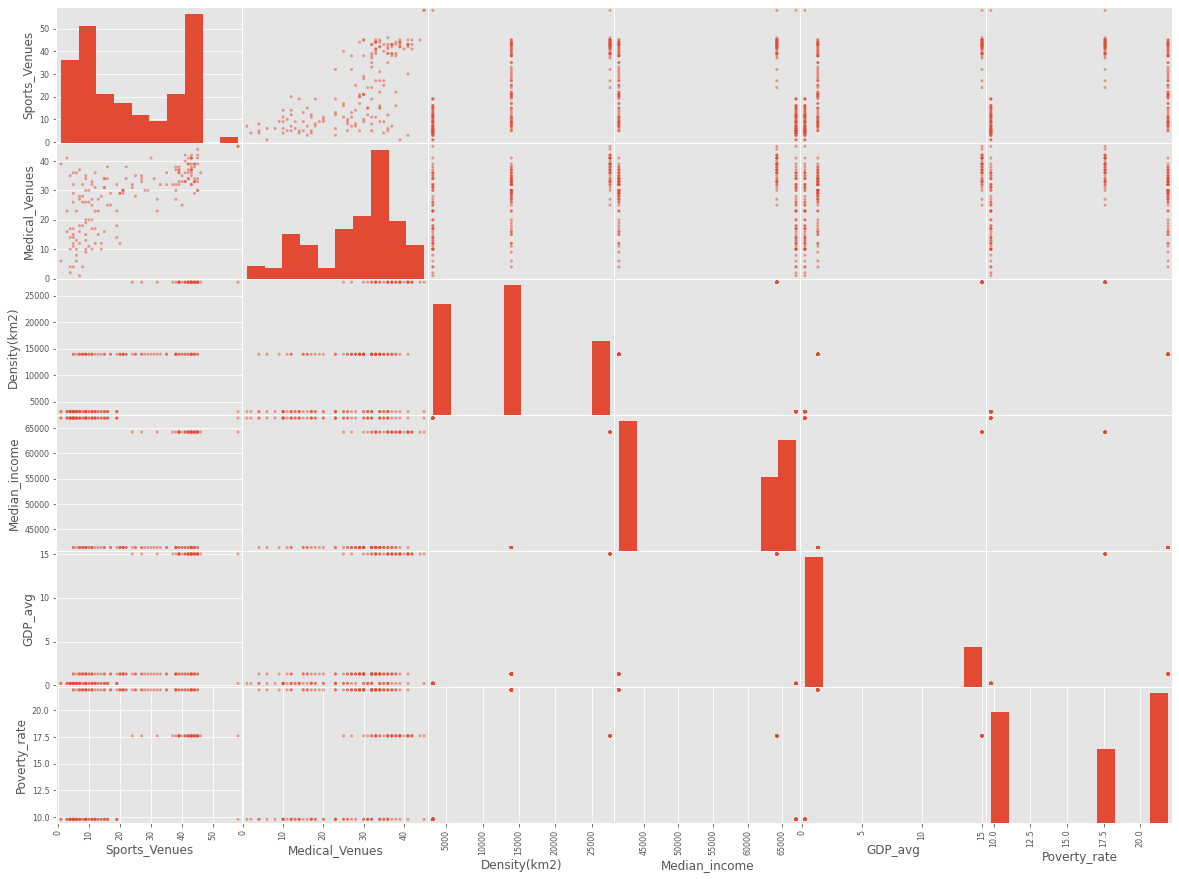

In [59]:
from pandas.plotting import scatter_matrix
attributes = ['Sports_Venues', 'Medical_Venues', 'Density(km2)','Median_income','GDP_avg', 'Poverty_rate']
scatter_matrix(ny3_df_join[attributes], figsize=(20,15))

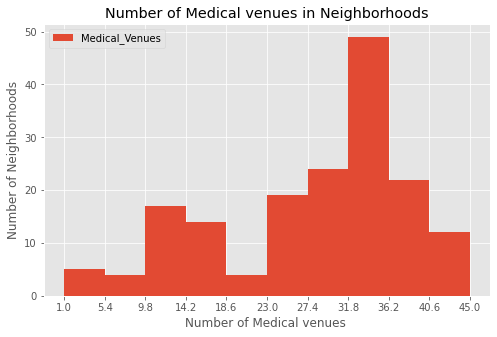

In [60]:
# Divide bin edges using np.histogram 
count, bin_edges = np.histogram(venues_medical_count) 
#
venues_medical_count.plot(kind='hist', figsize=(8,5), xticks=bin_edges)
plt.title("Number of Medical venues in Neighborhoods")
plt.ylabel("Number of Neighborhoods")
plt.xlabel("Number of Medical venues ")
plt.show()

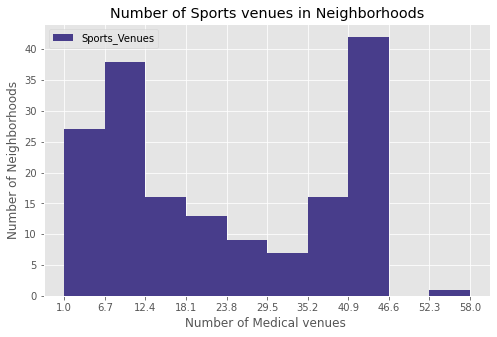

In [61]:
count, bin_edges = np.histogram(venues_sports_count) 
#
venues_sports_count.plot(kind='hist', figsize=(8,5), xticks=bin_edges, color='darkslateblue')
plt.title("Number of Sports venues in Neighborhoods")
plt.ylabel("Number of Neighborhoods")
plt.xlabel("Number of Medical venues ")
plt.show()

<AxesSubplot:xlabel='Sports_Venues', ylabel='Medical_Venues'>

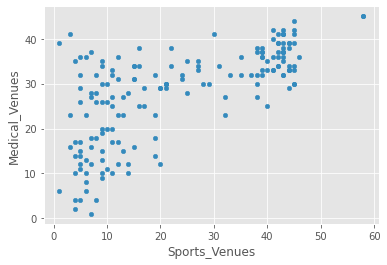

In [69]:
ny3_df_join.plot(kind="scatter", y='Medical_Venues', x='Sports_Venues', alpha=1)

### 4.2. Cluster Neighbourhoods

### A. The first clustering: Clustering neighborhoods into three groups with only two features

Since the number of medical and sprots venues vary each neighborhoods unlike other predictors, we will create a scattor plot to see how each neighborhoods are divided into each clusters in terms of accessibility of heathcare and excercise facilities.

In [64]:
df_2d = ny3_df_join.copy()
df_2d.head()

,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
0,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0,13957.0,1.307986,41406.0,21.9
1,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0,13957.0,1.307986,41406.0,21.9
2,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0,13957.0,1.307986,41406.0,21.9
3,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0,13957.0,1.307986,41406.0,21.9
4,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0,13957.0,1.307986,41406.0,21.9


In [94]:
### BUILD A TWO DIMENSIONS CLUSTER AGAIN ###
# k means
kmeans_2d = KMeans(n_clusters=3, random_state=0)
df_2d['cluster'] = kmeans_2d.fit_predict(df_2d[['Sports_Venues', 'Medical_Venues']])

# get centroids
centroids = kmeans_2d.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add two column which as x, y values of the centroids 
df_2d['cen_x'] = df_2d.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df_2d['cen_y'] = df_2d.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
df_2d['c'] = df_2d.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

<Figure size 432x288 with 0 Axes>

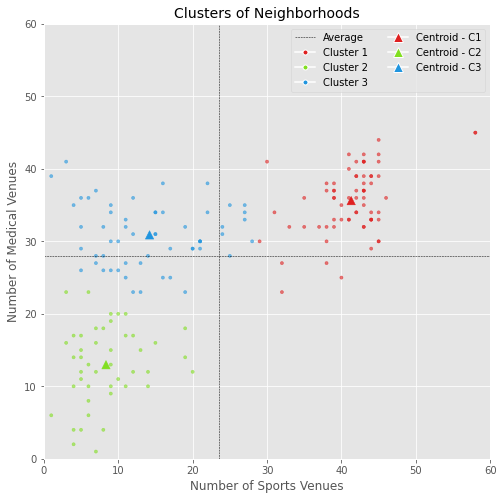

In [95]:
#####PLOT#####
from matplotlib.lines import Line2D
plt.clf()
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df_2d['Sports_Venues'],df_2d['Medical_Venues'], c=df_2d.c, alpha = 0.6, s=10)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# plot Attack mean
plt.plot([df_2d['Sports_Venues'].mean()]*2, [0,60], color='black', lw=0.5, linestyle='--')
plt.xlim(0,60)
# plot Defense mean
plt.plot([0,60], [df_2d['Medical_Venues'].mean()]*2, color='black', lw=0.5, linestyle='--')
plt.ylim(0,60)

# create a list of legend elemntes
## average line
legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]

## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)
# plot legend
plt.legend(handles=legend_elements, loc='upper right', ncol=2)
# x and y limits
plt.xlim(0,60)
plt.ylim(0,60)
# title and labels
plt.title('Clusters of Neighborhoods', loc='center', fontsize=14)
plt.xlabel('Number of Sports Venues')
plt.ylabel('Number of Medical Venues')

plt.show()

In [72]:
# add clustering labels
df_2d.insert(0,'Cluster_label', kmeans_2d.labels_)
df_2d.head()

,Cluster_label,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate,cluster,cen_x,cen_y,c
0,2,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0,13957.0,1.307986,41406.0,21.9,2,14.210526,30.894737,#2095DF
1,0,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0,13957.0,1.307986,41406.0,21.9,0,41.308824,35.617647,#DF2020
2,0,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0,13957.0,1.307986,41406.0,21.9,0,41.308824,35.617647,#DF2020
3,2,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0,13957.0,1.307986,41406.0,21.9,2,14.210526,30.894737,#2095DF
4,1,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0,13957.0,1.307986,41406.0,21.9,1,8.355556,12.977778,#81DF20


**_Cluster 1 -> Average values: Sports:41, Medical:37_**

In [92]:
c1 = df_2d.loc[df_2d['Cluster_label'] == 0, df_2d.columns[[2,3]+list(range(6,8))]]
# c1.head()
c1.describe()

,Sports_Venues,Medical_Venues
count,68.000000,68.000000
mean,41.308824,35.617647
std,4.902809,4.600550
min,29.000000,23.000000
25%,39.000000,33.000000
50%,42.000000,36.000000
75%,44.000000,39.000000
max,58.000000,45.000000


**_Cluster 2 -> Average values: Sports:8, Medical:13_**

In [96]:
c2 = df_2d.loc[df_2d['Cluster_label'] == 1, df_2d.columns[[2,3]+list(range(6,8))]]
# c1.head()
c2.describe()

,Sports_Venues,Medical_Venues
count,45.000000,45.000000
mean,8.355556,12.977778
std,4.411532,5.370326
min,1.000000,1.000000
25%,5.000000,10.000000
50%,7.000000,13.000000
75%,11.000000,17.000000
max,20.000000,23.000000


**_Cluster 3 -> Average values: Sports:14, Medical:31_**

In [97]:
c3 = df_2d.loc[df_2d['Cluster_label'] == 2, df_2d.columns[[2,3]+list(range(6,8))]]
# c1.head()
c3.describe()

,Sports_Venues,Medical_Venues
count,57.000000,57.000000
mean,14.210526,30.894737
std,7.118228,4.253923
min,1.000000,23.000000
25%,9.000000,28.000000
50%,13.000000,31.000000
75%,20.000000,34.000000
max,28.000000,41.000000


In [87]:
#import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 3

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_2d['Latitude'], df_2d['Longitude'], df_2d['Neighborhood'], df_2d['Cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### B.The second clustering: Clustering neighborhoods into six groups with all features

In [98]:
# In case we repreat the process, spare the original raw joined data
df = ny3_df_join.copy()
df_f = df[attributes]

In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_f_s = scaler.fit_transform(df_f)

In [100]:
# set number of clusters
kclusters = 6 # from 7, it doenst matter
# run k-means clustering
# ny3_clustering = ny3_df_join.drop(['idx','Borough','Neighborhood'], 1)
# ny3_clustering.head()
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_f_s)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 3, 3, 5, 0, 3, 0, 5, 0, 3])

In [101]:
# add clustering labels
df.insert(0,'Cluster_label', kmeans.labels_)

In [102]:
df.head()

,Cluster_label,idx,Borough,Neighborhood,Latitude,Longitude,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
0,5,1,Brooklyn,Bath Beach,40.599519,-73.998752,21.0,30.0,13957.0,1.307986,41406.0,21.9
1,3,1,Brooklyn,Bay Ridge,40.625801,-74.030621,35.0,36.0,13957.0,1.307986,41406.0,21.9
2,3,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,38.0,27.0,13957.0,1.307986,41406.0,21.9
3,5,1,Brooklyn,Bensonhurst,40.611009,-73.995180,21.0,30.0,13957.0,1.307986,41406.0,21.9
4,0,1,Brooklyn,Bergen Beach,40.615150,-73.898556,5.0,11.0,13957.0,1.307986,41406.0,21.9


**_Cluster 1: Brooklyn A_**

In [103]:
c1_Br_a = df.loc[df['Cluster_label'] == 0, df.columns[[2,3]+list(range(6,12))]]
c1_Br_a.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
4,Brooklyn,Bergen Beach,5.0,11.0,13957.0,1.307986,41406.0,21.9
6,Brooklyn,Borough Park,7.0,16.0,13957.0,1.307986,41406.0,21.9
8,Brooklyn,Broadway Junction,10.0,20.0,13957.0,1.307986,41406.0,21.9
14,Brooklyn,City Line,9.0,19.0,13957.0,1.307986,41406.0,21.9
17,Brooklyn,Coney Island,15.0,16.0,13957.0,1.307986,41406.0,21.9


**_Cluster 2: Manhattan_**

In [106]:
c2_St_a = df.loc[df['Cluster_label'] == 1, df.columns[[2,3]+list(range(6,12))]]
c2_St_a.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
70,Manhattan,Battery Park City,43.0,41.0,27544.0,15.0061,64217.0,17.6
71,Manhattan,Carnegie Hill,43.0,42.0,27544.0,15.0061,64217.0,17.6
72,Manhattan,Central Harlem,39.0,36.0,27544.0,15.0061,64217.0,17.6
73,Manhattan,Chelsea,58.0,45.0,27544.0,15.0061,64217.0,17.6
74,Manhattan,Chinatown,43.0,37.0,27544.0,15.0061,64217.0,17.6


**_Cluster 3: Staten Island A_**

In [108]:
c3_Ma = df.loc[df['Cluster_label'] == 2, df.columns[[2,3]+list(range(6,12))]]
c3_Ma.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
116,Staten Island,Bulls Head,16.0,34.0,3150.0,0.230381,66985.0,9.8
118,Staten Island,Castleton Corners,15.0,31.0,3150.0,0.230381,66985.0,9.8
120,Staten Island,Chelsea,58.0,45.0,3150.0,0.230381,66985.0,9.8
122,Staten Island,Concord,8.0,32.0,3150.0,0.230381,66985.0,9.8
123,Staten Island,Dongan Hills,13.0,27.0,3150.0,0.230381,66985.0,9.8


**_Cluster 4: Brooklyn B_**

In [109]:
c4_Br_b = df.loc[df['Cluster_label'] == 3, df.columns[[2,3]+list(range(6,12))]]
c4_Br_b.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
1,Brooklyn,Bay Ridge,35.0,36.0,13957.0,1.307986,41406.0,21.9
2,Brooklyn,Bedford Stuyvesant,38.0,27.0,13957.0,1.307986,41406.0,21.9
5,Brooklyn,Boerum Hill,45.0,30.0,13957.0,1.307986,41406.0,21.9
9,Brooklyn,Brooklyn Heights,42.0,34.0,13957.0,1.307986,41406.0,21.9
11,Brooklyn,Bushwick,38.0,30.0,13957.0,1.307986,41406.0,21.9


**_Cluster 5: Staten Island B_**

In [110]:
c5_St_b = df.loc[df['Cluster_label'] == 4, df.columns[[2,3]+list(range(6,12))]]
c5_St_b.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
110,Staten Island,Annadale,6.0,8.0,3150.0,0.230381,66985.0,9.8
111,Staten Island,Arden Heights,5.0,12.0,3150.0,0.230381,66985.0,9.8
112,Staten Island,Arlington,1.0,6.0,3150.0,0.230381,66985.0,9.8
113,Staten Island,Arrochar,12.0,12.0,3150.0,0.230381,66985.0,9.8
114,Staten Island,Bay Terrace,9.0,20.0,3150.0,0.230381,66985.0,9.8


**_Cluster 6: Brooklyn C_**

In [111]:
c6_Br_c = df.loc[df['Cluster_label'] == 5, df.columns[[2,3]+list(range(6,12))]]
c6_Br_c.head()

,Borough,Neighborhood,Sports_Venues,Medical_Venues,Density(km2),GDP_avg,Median_income,Poverty_rate
0,Brooklyn,Bath Beach,21.0,30.0,13957.0,1.307986,41406.0,21.9
3,Brooklyn,Bensonhurst,21.0,30.0,13957.0,1.307986,41406.0,21.9
7,Brooklyn,Brighton Beach,21.0,29.0,13957.0,1.307986,41406.0,21.9
10,Brooklyn,Brownsville,12.0,23.0,13957.0,1.307986,41406.0,21.9
12,Brooklyn,Canarsie,10.0,26.0,13957.0,1.307986,41406.0,21.9


In [113]:
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results and Discussion <a name="results"></a>

In the last step, neighborhoods were segmented in two different ways: the first clustering was determined by only the accessibility of medical care and fitness-related services and the other was by all features including its financial conditions and a population density which contribute to the quality of the physical environment of neighborhoods. 

In the first clustering, neighborhoods from Brooklyn and State Island were divided into two groups regardless of their boroughs. However, with all independent variables, neighborhoods strictly maintain its geographical boundaries and within its boroughs, it has different clusters. Manhattan with the highest accessibility and income has a very strong position among others because it remains the same cluster in both clusterings.

For further study, the result can be improved by adding several other features such as the number of fast-food restaurants and obesity rate.


## 6. Conclusion <a name="conclusion"></a>

The objective of this project is to help government health agencies that provide healthcare services get a better understanding of the citizens of New York City, especially the Manhattan data, the Brooklyn, and the Staten Island. As the neighborhoods were categorized into several groups based on their physical living environment, the agencies and companies can establish a public campaign or marketing strategy with different approaches depending on neighborhoods.